## 4. CRISP-DM: Data Preparation

In [422]:

# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display
import re
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from IPython.display import display, Markdown
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler


from imblearn.over_sampling import SMOTE 
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, confusion_matrix, recall_score, precision_score, roc_curve, f1_score

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # Render high resolution images

# Load datasets
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
weather = pd.read_csv('../data/weather.csv')
spray = pd.read_csv('../data/spray.csv')


### 4.1 Data Selection

In [423]:
import pandas as pd

# Assuming the dataframes train, test, weather, and spray are already defined
train.name = 'train'
test.name = 'test'
weather.name = 'weather'
spray.name = 'spray'



#### Feature Extraction

**Extracting Number of WNV Cases Per Location**

In [424]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'train' is your DataFrame containing the data
# Create a pivot table to sum the number of WNV cases detected at each location
wnv_risk = train.groupby('Address').agg({'WnvPresent': 'sum'}).reset_index()

# Display statistics of WNV cases detected
print(wnv_risk.describe().round()) 

# Define bins and labels for Risk Assessment: 0 cases, 1-2 cases, 3-6 cases, 7-10 cases, more than 10 cases
bins = [0, 1, 3, 7, 11, float('inf')]
labels = [1, 2, 3, 4, 5]  # Numeric labels corresponding to risk levels

# Create the WNV_risk feature with numeric labels
# Convert labels to integers to ensure the column is numerical
wnv_risk['WNV_risk'] = pd.cut(wnv_risk['WnvPresent'], bins=bins, right=False, labels=labels).astype(int)

# Merge risk data with train data
train = train.merge(wnv_risk[['Address', 'WNV_risk']], how='left', on='Address')

display(train.head())


       WnvPresent
count       138.0
mean          4.0
std           7.0
min           0.0
25%           0.0
50%           2.0
75%           6.0
max          66.0


,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,WNV_risk
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,5
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,5
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,1
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,3
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,3


Extracting Feature Relative Humidity

In [425]:
# The weather conditions are encoded in the CodeSum column. We weill use Rainy, Snowy, Windy, Hazy as Umbrella Terms for various Conditions
weather["CodeSum"].unique()

# List of valid weather codes
codes = ['+FC','FC', 'TS', 'GR', 'RA', 'DZ', 'SN', 'SG', 'GS', 'PL',
         'IC', 'FG+', 'FG', 'BR', 'UP', 'HZ', 'FU', 'VA', 'DU', 'DS',
         'PO', 'SA', 'SS', 'PY', 'SQ', 'DR', 'SH', 'FZ', 'MI', 'PR',
         'BC', 'BL', 'VC']

# Function to clean and filter codes in CodeSum
def clean_codes(code_string):
    filtered_codes = [code for code in code_string.split() if code in codes]
    return ' '.join(filtered_codes)

# Apply the function to the CodeSum column
weather['CodeSum'] = weather['CodeSum'].apply(clean_codes)


conditions = {
    "Precipitation": ['RA', 'DZ', 'SN', 'SG', 'GS', 'PL', 'SH', 'UP', 'DR', 'BC'],
    "Visibility Issues": ['FG', 'BR', 'HZ', 'FU'],
    "Windy": ['SQ', 'SS', 'DS', 'PO'],
    "Very Hot": [],  # Assuming no codes directly indicate high temperatures
    "Very Cold": ['IC', 'FZ'],  # Freezing and ice crystals indicate very cold conditions
    "Cloudy": ['FG+', 'MI', 'PR', 'VC'],  # Including mist and partial clouds
    "Atmospheric Phenomena": ['TS', 'GR', 'PY'],  # Thunderstorms, hail, and spray
    "Storms": ['FC', '+FC'],  # Funnel clouds and tornadoes
    "Miscellaneous": ['DU', 'BL', 'SA', 'VA']  # Miscellaneous particulates and phenomena
}

# Function to create dummy variables based on conditions
def mark_conditions(row, condition_codes):
    return any(code in row['CodeSum'].split() for code in condition_codes)

# Apply the function to create dummy columns for each condition
for condition, codes in conditions.items():
    weather[condition] = weather.apply(mark_conditions, condition_codes=codes, axis=1).astype(int)





<!-- **Assigning a station based on longitude and latitude**: This feature Is necessary for Data Integration (merging the 2 Dataframes) -->

#### Data Selection




In order to reduce the complexity and choose the most important features, we used general knowledge and domain knowledge.
TODO: Differentiate between test and train
#### Train and Test Data

**Features to Keep:**
- **`Date`**: Temporal patterns can influence mosquito activity and WNV presence. [2]
- **`Species`**: Different mosquito species have varying propensities to carry WNV. [3]
- **`Address`**: Geographic location is critical for spatial analysis of virus presence. Using address instead of coordinates allows us to categorize coordinates and assign them with a risk level (see code above).
- **`Trap`**: Specific traps might have consistent results based on their locations.
- **`NumMosquitos`**: Higher mosquito counts might correlate with a higher likelihood of virus presence.

**Features to Drop:**
- ~~**`Block`**~~: Redundant when using Latitude and Longitude.
- ~~**`Street`**~~: Not useful for modeling; geographical coordinates are more precise.
- ~~**`AddressNumberAndStreet`**~~: Redundant when using Address.
- ~~**`AddressAccuracy`**~~: Provided geocoded data already has adequate accuracy.
- ~~**`Latitude`**, **`Longitude`**~~: Already using Address.

#### Weather Data

"Mosquito seasonal activity is largely driven by weather conditions, most notably temperature, precipitation, and relative humidity." [5]

**Features to Keep:**
- **`Station`**: Different weather stations can provide location-specific weather data.
- **`Date`**: Temporal patterns can influence mosquito activity and WNV presence. [2]
- **`Tmax`**, **`Tmin`**, **`Tavg`**: Temperature extremes and averages can influence mosquito behavior. [2]
- **`DewPoint`**: Indicator of moisture in the air, which can affect mosquito breeding.
- **`PrecipTotal`**: Total precipitation; standing water is critical for mosquito breeding.
- **`StnPressure`**: Has an impact on population [7]
- **`ResultSpeed`**, **`ResultDir`**, **`AvgSpeed`**: Wind speed and direction are not nearly as relevant as temperature, precipitation, and relative humidity, but should still be icnluded, as it can affect flight activity [8].

**Features to Drop:**
- ~~**`Depth`**~~: Unnecessary, since we already have precipitation
- ~~**`SeaLevel`**~~: Likely has very little impact especially, since chicago isn't a coastal city
- ~~**`Depart`**~~: Departure from average might not be as useful as absolute values.
- ~~**`WetBulb`**~~: Similar information provided by DewPoint.
- ~~**`Heat`**, **`Cool`**~~: Redundant when using temperature data.
- ~~**`Sunrise`**, **`Sunset`**~~: Not as relevant as the other weather conditions [5]
- ~~**`CodeSum`**~~: We've already extracted a feature which aggregates these
- ~~**`SnowFall`**~~: Mosquitoes only exist in dormancy during winter (or when it snows) and do not breed or thrive in any capacity. [6]
- ~~**`Water1`**~~: Only has missing values.

### Spray Data

**Decision: Not to use Spray Data**

#### Reasoning:
1. **High Number of Missing Values**: The spray dataset contains many missing values, making it unreliable for modeling.
2. **Temporal and Spatial Misalignment**: The spray data often do not align temporally or spatially with the trap data, making it difficult to integrate meaningfully into the model.
3. **Community Practice**: Based on community discussions (e.g., on Kaggle), many practitioners choose to exclude the spray data due to its inconsistencies and the challenges it presents.

## References

[1] https://www.mdpi.com/2225-1154/7/9/101#:~:text=In%20climate%20science%2C%20climate%20departure,27%2C28%2C29%5D.

[2] https://eu.usatoday.com/story/news/2023/05/29/how-long-do-mosquitoes-live/70228628007/

[3] https://www.epa.gov/sites/default/files/2021-01/documents/wetlands_west_nile_virus.pdf

[4] https://www.wearegreenbay.com/weather/beyondtheforecast/what-weather-conditions-lead-to-mosquitos-being-more-active/#:~:text=Temperatures%20can%20get%20too%20hot,the%20cooler%20temperatures%20of%20winter.

[5] https://parasitesandvectors.biomedcentral.com/articles/10.1186/s13071-023-05760-x

[6] https://www.vdci.net/blog/where-do-mosquitoes-go-in-the-winter/#:~:text=By%20entering%20a%20state%20of,areas%20with%20significant%20seasonal%20variation.

[7] https://www.redalyc.org/journal/5763/576366658009/html/

[8]

In [426]:

weather.drop(["SeaLevel", "Depart", "WetBulb", "Heat", "Cool", "Sunrise", "Sunset", "CodeSum", "SnowFall", "Water1", "Depth"], axis=1, inplace=True)
for df in [train, test]:
  df.drop(["Block", "Street", "AddressNumberAndStreet", "AddressAccuracy", "Latitude", "Longitude"], axis=1, inplace=True)




### 4.2 Data Cleaning Based on Steps Outlined in [Slides for Data Preparation](/Vorlesungen/2024_08_Data%20Preparation.pdf) 

### Before

#### Data Cleansing

##### Turn all characters into capital letters to level case sensitivity

In [427]:

text_columns = ['Address', 'Species']

def level_case_sensitivity(df, columns):
    for column in columns:
        df[column] = df[column].str.upper()
        df[column] = df[column].str.strip()
    return df

train = level_case_sensitivity(train, text_columns)
test = level_case_sensitivity(test, text_columns)




##### Remove spaces and non-printing characters (\n, \t etc.)

In [428]:

def rm_spaces_nonprinting_chars(df, columns):
    for column in columns:
        df[column] = df[column].apply(lambda x: re.sub(r'[\n\t]', '', x) if isinstance(x, str) else x)
        # df[column] = df[column].apply(lambda x: replace_abbreviations(x, abbreviations) if isinstance(x, str) else x)
    return df
train = rm_spaces_nonprinting_chars(train, text_columns)
test = rm_spaces_nonprinting_chars(test, text_columns)



##### Convert numerical values into standard units, especially if data from different sources and different countries are used

In [429]:
import pandas as pd

# Define conversion functions
def fahrenheit_to_celsius(f):
    return round((f - 32) * 5.0 / 9.0, 2)

def inhg_to_mbar(inhg):
    return round(inhg * 33.8639, 2)

def mph_to_kmph(mph):
    return round(mph * 1.60934, 2)

# Convert relevant columns to numeric type if they are not already
numeric_columns = ['Tmax', 'Tmin', 'Tavg', 'StnPressure', 'AvgSpeed', 'ResultSpeed']
weather[numeric_columns] = weather[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Applying conversions to the DataFrame
weather['Tmax'] = weather['Tmax'].apply(fahrenheit_to_celsius)
weather['Tmin'] = weather['Tmin'].apply(fahrenheit_to_celsius)
weather['Tavg'] = weather['Tavg'].apply(fahrenheit_to_celsius)
weather['StnPressure'] = weather['StnPressure'].apply(inhg_to_mbar)
weather['AvgSpeed'] = weather['AvgSpeed'].apply(mph_to_kmph)
weather['ResultSpeed'] = weather['ResultSpeed'].apply(mph_to_kmph)
weather['DewPoint'] = weather['DewPoint'].apply(fahrenheit_to_celsius)

# Print updated dataframe to check changes
display(weather.head())


,Station,Date,Tmax,Tmin,Tavg,DewPoint,PrecipTotal,StnPressure,ResultSpeed,ResultDir,AvgSpeed,Precipitation,Visibility Issues,Windy,Very Hot,Very Cold,Cloudy,Atmospheric Phenomena,Storms,Miscellaneous
0,1,2007-05-01,28.33,10.00,19.44,10.56,0.00,985.44,2.74,27,14.81,0,0,0,0,0,0,0,0,0
1,2,2007-05-01,28.89,11.11,20.00,10.56,0.00,988.15,4.35,25,15.45,0,0,0,0,0,0,0,0,0
2,1,2007-05-02,15.00,5.56,10.56,5.56,0.00,994.92,20.92,4,21.57,0,1,0,0,0,0,0,0,0
3,2,2007-05-02,15.56,6.11,11.11,5.56,0.00,996.95,21.40,2,21.57,0,1,0,0,0,0,0,0,0
4,1,2007-05-03,18.89,7.78,13.33,4.44,0.00,995.26,18.83,7,19.15,0,0,0,0,0,0,0,0,0



##### Use dictionaries containing all possible values of an attribute to assure that all values comply with the domain knowledge

In [430]:
import os
import json
import pandas as pd
from datetime import time

def write_unique_values_to_json(dataframes, output_directory):
    # Ensure the output directory exists
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Function to handle non-serializable data types
    def default_converter(o):
        if isinstance(o, pd.Timestamp):
            return o.isoformat()
        elif isinstance(o, pd.Timedelta):
            return str(o)
        elif isinstance(o, pd._libs.tslibs.nattype.NaTType):
            return None
        elif isinstance(o, time):
            return o.strftime('%H:%M:%S')
        raise TypeError(f"Object of type {o.__class__.__name__} is not JSON serializable")
    
    # Iterate over each dataframe
    for df in dataframes:
        # Ensure the dataframe has a name attribute
        if not hasattr(df, 'name'):
            raise AttributeError("DataFrame is missing a 'name' attribute")
        
        # Create a dictionary to store unique values for each column
        unique_values_dict = {}
        
        # Iterate over each column in the dataframe
        for column in df.columns:
            # Get unique values and convert them to a list
            unique_values = df[column].dropna().unique().tolist()
            # Convert any non-serializable items
            unique_values = [x if isinstance(x, (int, float, str)) else default_converter(x) for x in unique_values]
            # Store unique values in the dictionary
            unique_values_dict[column] = unique_values
        
        # Construct the output file path
        output_file = os.path.join(output_directory, f'{df.name}_unique_values.json')
        
        # Write the unique values dictionary to a JSON file
        with open(output_file, 'w') as f:
            
            
            json.dump(unique_values_dict, f, indent=4)
        
        print(f'Unique values for {df.name} written to {output_file}')



train.name = 'train'
test.name = 'test'
weather.name = 'weather'

# Specify output directory
output_directory = '../data/unique_values_output'

# Call the function with the list of DataFrames
write_unique_values_to_json([train, test, weather], output_directory)



Unique values for train written to ../data/unique_values_output\train_unique_values.json
Unique values for test written to ../data/unique_values_output\test_unique_values.json
Unique values for weather written to ../data/unique_values_output\weather_unique_values.json


#### Missing Values (used RandomForest Classifier to predict if value is missing or not to determine MCAR, MNAR, MAR)


In [431]:
import pandas as pd
import numpy as np
from IPython.display import display, Markdown
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# List of custom missing values
# missing_values = ['', 'M', '-']
missing_values = []

# Function to replace custom missing values with NaN
def standardize_missing_values(df, missing_values):
    return df.replace(missing_values, np.nan)

# Apply the function to standardize missing values in all dataframes
for df in [train, test, weather]:
    df = standardize_missing_values(df, missing_values)

def analyze_dataframe(df, name):
    display(Markdown(f"### {name} DataFrame Analysis"))
    
    # Missing value analysis
    null_values = df.isnull().sum()
    if null_values.any():
        display(Markdown("**Missing Values Detected by `isnull()`**"))
        display(null_values[null_values > 0])

    # Custom missing values analysis
    for value in missing_values:
        specific_value_count = df.isin([value]).sum()
        if specific_value_count.any():
            display(Markdown(f"**Custom Missing Value '{value}' Detected**"))
            display(specific_value_count[specific_value_count > 0].sort_values(ascending=False))

    # Predictive missingness analysis
    results = {}
    feature_importances = {}
    for col in df.columns:
        if df[col].isnull().any():
            df[f'{col}_missing'] = df[col].isnull().astype(int)
            X = df.drop(columns=[col, f'{col}_missing'])
            y = df[f'{col}_missing']

            for c in X.columns:
                if X[c].dtype == 'object':
                    X[c] = pd.factorize(X[c])[0]
                elif pd.api.types.is_datetime64_any_dtype(X[c]):
                    X[c] = X[c].view('int64')

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
            clf = RandomForestClassifier(n_estimators=100, random_state=42)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)

            accuracy = accuracy_score(y_test, y_pred)
            misclassification_rate = 1 - accuracy
            expected_rate = max(y.mean(), 1 - y.mean())

            results[col] = {
                'accuracy': accuracy,
                'misclassification_rate': misclassification_rate,
                'expected_rate': expected_rate,
                'comment': 'Not MCAR' if misclassification_rate < expected_rate else 'Potentially MCAR'
            }

            # Feature importance analysis
            feature_importances[col] = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)

            df.drop(columns=[f'{col}_missing'], inplace=True)
    
    if results:
        display(Markdown("### Predictive Missingness Analysis Results"))
        for col, res in results.items():
            display(Markdown(f"**Column:** {col}"))
            display(Markdown(f"- Accuracy: {res['accuracy']:.4f}"))
            display(Markdown(f"- Misclassification Rate: {res['misclassification_rate']:.4f}"))
            display(Markdown(f"- Expected Rate: {res['expected_rate']:.4f}"))
            display(Markdown(f"- Comment: {res['comment']}"))
            display(Markdown("**Top Predictive Features**"))
            top_features = feature_importances[col].head(5)
            for feature, importance in top_features.items():
                display(Markdown(f"- {feature}: {importance:.4f}"))

# Example usage:
analyze_dataframe(weather, "Weather")
analyze_dataframe(train, "Train")
analyze_dataframe(test, "Test")


### Weather DataFrame Analysis

**Missing Values Detected by `isnull()`**

Tavg           11
StnPressure     4
AvgSpeed        3
dtype: int64

### Predictive Missingness Analysis Results

**Column:** Tavg

- Accuracy: 0.9966

- Misclassification Rate: 0.0034

- Expected Rate: 0.9963

- Comment: Not MCAR

**Top Predictive Features**

- AvgSpeed: 0.1727

- Date: 0.1368

- Tmax: 0.1140

- DewPoint: 0.1043

- ResultSpeed: 0.0971

**Column:** StnPressure

- Accuracy: 0.9977

- Misclassification Rate: 0.0023

- Expected Rate: 0.9986

- Comment: Not MCAR

**Top Predictive Features**

- Date: 0.1869

- DewPoint: 0.1765

- AvgSpeed: 0.1241

- ResultDir: 0.1236

- Tmin: 0.1048

**Column:** AvgSpeed

- Accuracy: 0.9989

- Misclassification Rate: 0.0011

- Expected Rate: 0.9990

- Comment: Not MCAR

**Top Predictive Features**

- Tavg: 0.1644

- DewPoint: 0.1596

- Date: 0.1346

- Tmin: 0.1034

- ResultSpeed: 0.0912

### Train DataFrame Analysis

### Test DataFrame Analysis

In [432]:
# Insignificant Precipitation is marked as 'T'. We will replace it with 0. This is necessary for the next steps
low_values=['T', ' T', '  T']
weather['PrecipTotal'].replace(low_values, 0, inplace=True)

Since all of the Values are not MCAR, we COULD impute them using Multiple Imputation - Bayesian Procedure. This would look something like this ...

In [433]:
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer  # This might be necessary
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
def impute_missing_values_bayesian(df):
    # Identify non-numeric columns to exclude from imputation
    numeric_cols = df.select_dtypes(include=[np.number, 'datetime64[ns]']).columns
    non_numeric_cols = df.columns.difference(numeric_cols)

    # Only include numeric and datetime columns in the imputation process
    df_numeric = df[numeric_cols].copy()  # Use copy to avoid SettingWithCopyWarning

    # Convert datetime columns to Unix timestamp
    datetime_cols = df_numeric.select_dtypes(include=['datetime64[ns]']).columns
    for col in datetime_cols:
        df_numeric.loc[:, col] = df_numeric[col].astype('int64') / 1e9  # Use loc for safe in-place modification

    # Perform the imputation on numeric data
    imputer = IterativeImputer(estimator=BayesianRidge(), missing_values=np.nan, max_iter=10, random_state=42, initial_strategy='mean')
    imputed_data = imputer.fit_transform(df_numeric)
    df_numeric_imputed = pd.DataFrame(imputed_data, index=df_numeric.index, columns=numeric_cols)

    # Convert back numeric datetime columns to datetime
    for col in datetime_cols:
        df_numeric_imputed[col] = pd.to_datetime(df_numeric_imputed[col], unit='s')

    # Reintegrate the non-numeric data
    df_imputed = pd.concat([df_numeric_imputed, df[non_numeric_cols]], axis=1)

    return df_imputed

  

However, since there are so few Data Missing, we can also drop them or simply imnpute them using more primitive methods, since this will have no significant impact on the final result


<!-- <div style="color:red;">???? ⬇️<div> - Since we have so few missing values, we used the median - is this alright or do we need to do extensive analysis to determine if values are MCAR, MAR, etc. -->

In [434]:

weather['Tavg'] = (weather['Tmax'] + weather['Tmin']) / 2


weather.dropna(subset=['StnPressure', 'AvgSpeed'], inplace=True)

import numpy as np

# Function to calculate relative humidity
def calculate_relative_humidity(T, D):
    return 100 * np.exp((17.625 * D) / (243.04 + D) - (17.625 * T) / (243.04 + T))

# Calculate relative humidity and add it to the DataFrame
weather['RelativeHumidity'] = calculate_relative_humidity(weather['Tavg'], weather['DewPoint'])

# Display the DataFrame to verify the new column
display(weather.head())

weather.describe()


,Station,Date,Tmax,Tmin,Tavg,DewPoint,PrecipTotal,StnPressure,ResultSpeed,ResultDir,...,Precipitation,Visibility Issues,Windy,Very Hot,Very Cold,Cloudy,Atmospheric Phenomena,Storms,Miscellaneous,RelativeHumidity
0,1,2007-05-01,28.33,10.00,19.165,10.56,0.00,985.44,2.74,27,...,0,0,0,0,0,0,0,0,0,57.445764
1,2,2007-05-01,28.89,11.11,20.000,10.56,0.00,988.15,4.35,25,...,0,0,0,0,0,0,0,0,0,54.542570
2,1,2007-05-02,15.00,5.56,10.280,5.56,0.00,994.92,20.92,4,...,0,1,0,0,0,0,0,0,0,72.538398
3,2,2007-05-02,15.56,6.11,10.835,5.56,0.00,996.95,21.40,2,...,0,1,0,0,0,0,0,0,0,69.905852
4,1,2007-05-03,18.89,7.78,13.335,4.44,0.00,995.26,18.83,7,...,0,0,0,0,0,0,0,0,0,54.851906


,Station,Tmax,Tmin,Tavg,DewPoint,StnPressure,ResultSpeed,ResultDir,AvgSpeed,Precipitation,Visibility Issues,Windy,Very Hot,Very Cold,Cloudy,Atmospheric Phenomena,Storms,Miscellaneous,RelativeHumidity
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.00000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.0,2938.0,2938.000000,2938.000000,2938.0,2938.0,2938.000000
mean,1.499660,24.532764,14.331171,19.431967,11.920980,991.681464,11.20566,17.506467,13.810766,0.327774,0.299864,0.001021,0.0,0.0,0.009190,0.034717,0.0,0.0,62.830951
std,0.500085,6.369569,5.767691,5.852777,5.935604,5.369164,5.77867,10.059685,5.067189,0.469482,0.458276,0.031944,0.0,0.0,0.095439,0.183095,0.0,0.0,11.489180
min,1.000000,5.000000,-1.670000,1.945000,-5.560000,966.810000,0.16000,1.000000,2.740000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,29.989924
25%,1.000000,20.560000,10.000000,15.555000,7.780000,988.490000,6.92000,7.000000,10.140000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,54.773390
50%,1.000000,25.560000,15.000000,20.280000,12.220000,991.530000,10.30000,19.000000,13.040000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,62.175001
75%,2.000000,29.440000,18.890000,23.890000,16.670000,995.260000,14.81000,25.000000,16.740000,1.000000,1.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,70.325159
max,2.000000,40.000000,28.330000,34.165000,23.890000,1011.180000,38.79000,36.000000,42.330000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,0.0,0.0,107.144876


Now, that we've handled the missing values for weather, we can extract Relative humidity

In [435]:
    train['Date'] = pd.to_datetime(train['Date'])
    test['Date'] = pd.to_datetime(test['Date'])
    weather['Date'] = pd.to_datetime(weather['Date'])
    weather['Tavg'] = pd.to_numeric(weather['Tavg'])
    weather['StnPressure'] = pd.to_numeric(weather['StnPressure'])
    weather['AvgSpeed'] = pd.to_numeric(weather['AvgSpeed'])
    weather['RelativeHumidity'] = pd.to_numeric(weather['RelativeHumidity'])


##### Outlier Detection

In [436]:
import pandas as pd

import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_category_frequencies_grid(df):
    # Filter out categorical columns
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object' or pd.api.types.is_categorical_dtype(df[col])]
    
    # Determine the layout of the grid based on the number of categorical columns
    n_cols = min(3, len(categorical_columns))  # Use up to 3 columns in the grid
    n_rows = (len(categorical_columns) + 2) // 3  # Calculate required rows, rounded up

    # Setup the figure and axes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))  # Increased width for better label fitting
    fig.suptitle('Frequency of Categories in Each Column')

    # Loop over the grid and plot each variable
    for ax, column in zip(axes.flatten(), categorical_columns):
        # Get the frequency of each category, sorted by frequency, and keep only top 10
        frequency = df[column].value_counts().nlargest(10)
        
        # Decide on bar type based on number of categories
        if len(frequency) > 5:
            frequency.plot(kind='barh', ax=ax, color='skyblue')
            ax.invert_yaxis()  # Highest frequency on top
        else:
            frequency.plot(kind='bar', ax=ax, color='skyblue')
            ax.tick_params(axis='x', rotation=45, ha='right')

        ax.set_title(f'{column}')
        ax.set_xlabel('Category' if len(frequency) <= 5 else '')
        ax.set_ylabel('Frequency' if len(frequency) > 5 else 'Category')

        # Only use integer locator if using horizontal bars
        if len(frequency) > 5:
            ax.xaxis.set_major_locator(MaxNLocator(10))  # Limit the number of x-ticks

    # Hide any unused axes in the grid
    for i in range(len(categorical_columns), n_rows * n_cols):
        axes.flatten()[i].set_visible(False)

    # Adjust layout to handle overlap and tight fitting
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



from IPython.display import display, Markdown

def five_number_summary(data):
    """
    Compute and display the five-number summary for each numerical column in a DataFrame using Markdown.
    
    Parameters:
    - data (DataFrame): The DataFrame for which the summary is computed.
    """
    # Iterate through each numerical column in the DataFrame
    output = []
    for column in data.select_dtypes(include=['number']).columns:
        min_val = np.min(data[column])
        q1 = np.percentile(data[column], 25)
        median = np.median(data[column])
        q3 = np.percentile(data[column], 75)
        max_val = np.max(data[column])

        # Collect the summary for each column in Markdown format
        output.append(f"### {column} Summary")
        output.append(f"- Minimum: {min_val}")
        output.append(f"- Q1: {q1}")
        output.append(f"- Median: {median}")
        output.append(f"- Q3: {q3}")
        output.append(f"- Maximum: {max_val}\n")

    # Display all outputs as a single Markdown block
    display(Markdown('\n'.join(output)))


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def display_grid_boxplots(data, title):
    """
    Display grid boxplots for all numerical columns of a DataFrame in a 2x3 grid.

    Parameters:
    - data (DataFrame): The dataset to plot.
    - title (str): The title of the figure.
    """
    # Select only numerical columns from the DataFrame
    numerical_data = data.select_dtypes(include=['number'])
    columns = numerical_data.columns
    
    # Determine the layout of the grid based on the number of numerical columns
    n_cols = min(3, len(columns))  # Use up to 3 columns in the grid
    n_rows = (len(columns) + 2) // 3  # Calculate required rows, rounded up

    # Setup the figure and axes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), squeeze=False)
    fig.suptitle(title)

    # Loop over the grid and plot each variable
    for ax, column in zip(axes.flatten(), columns):
        sns.boxplot(y=column, data=data, ax=ax)
        ax.set_title(f'{column}')  # Use the column name as title

    # If there are any leftover axes, hide them
    for i in range(len(columns), n_rows * n_cols):
        axes.flatten()[i].set_visible(False)

    # Adjust layout to handle overlap and tight fitting
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rectangle in the figure part of the layout
    plt.show()




In [437]:
weather_numerical = weather.select_dtypes(include=['float64', 'int64'])
train_numerical = train.select_dtypes(include=['float64', 'int64'])
spray_numerical = spray.select_dtypes(include=['float64', 'int64'])
test_numerical = test.select_dtypes(include=['float64', 'int64'])
# Assuming 'weather', 'train', 'spray', and 'test' are pandas DataFrames already loaded into your environment

# Extract non-numerical columns


weather_categorical = weather.select_dtypes(exclude=weather_numerical.dtypes.to_dict().values())
# weather_categorical.drop(["Date"], axis=1, inplace=True) # frequency of categories in Date is not useful, because we have too many values to display them in a concise way
# weather_categorical.drop(["Year Month"], axis=1, inplace=True)  # frequency of categories in Date is not useful, because we have too many values to display them in a concise way
train_categorical = train.select_dtypes(exclude=train_numerical.dtypes.to_dict().values())
test_categorical = test.select_dtypes(exclude=test_numerical.dtypes.to_dict().values())



**Weather Outlier Detection - Categorical Attributes**

C:\Users\nilst\AppData\Local\Temp\ipykernel_16072\4129951889.py:15: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  categorical_columns = [col for col in df.columns if df[col].dtype == 'object' or pd.api.types.is_categorical_dtype(df[col])]


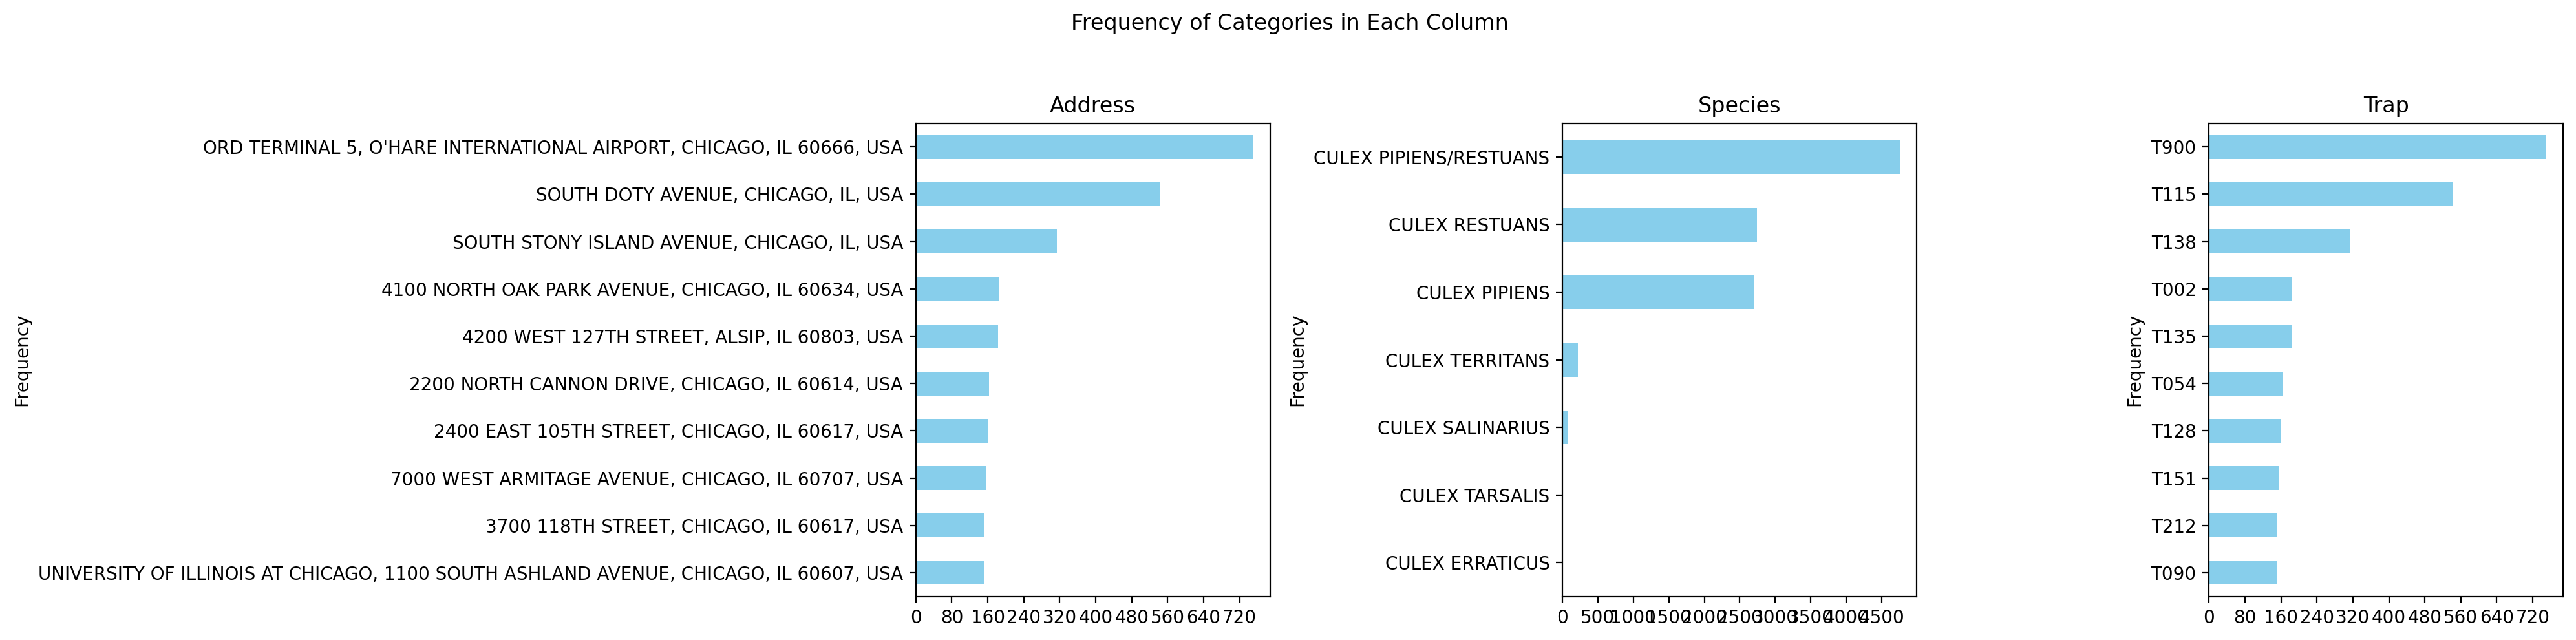

In [438]:
# Weather has no further categorical columns
plot_category_frequencies_grid(train_categorical)

**Weather Outlier Detection - Numerical Attributes**

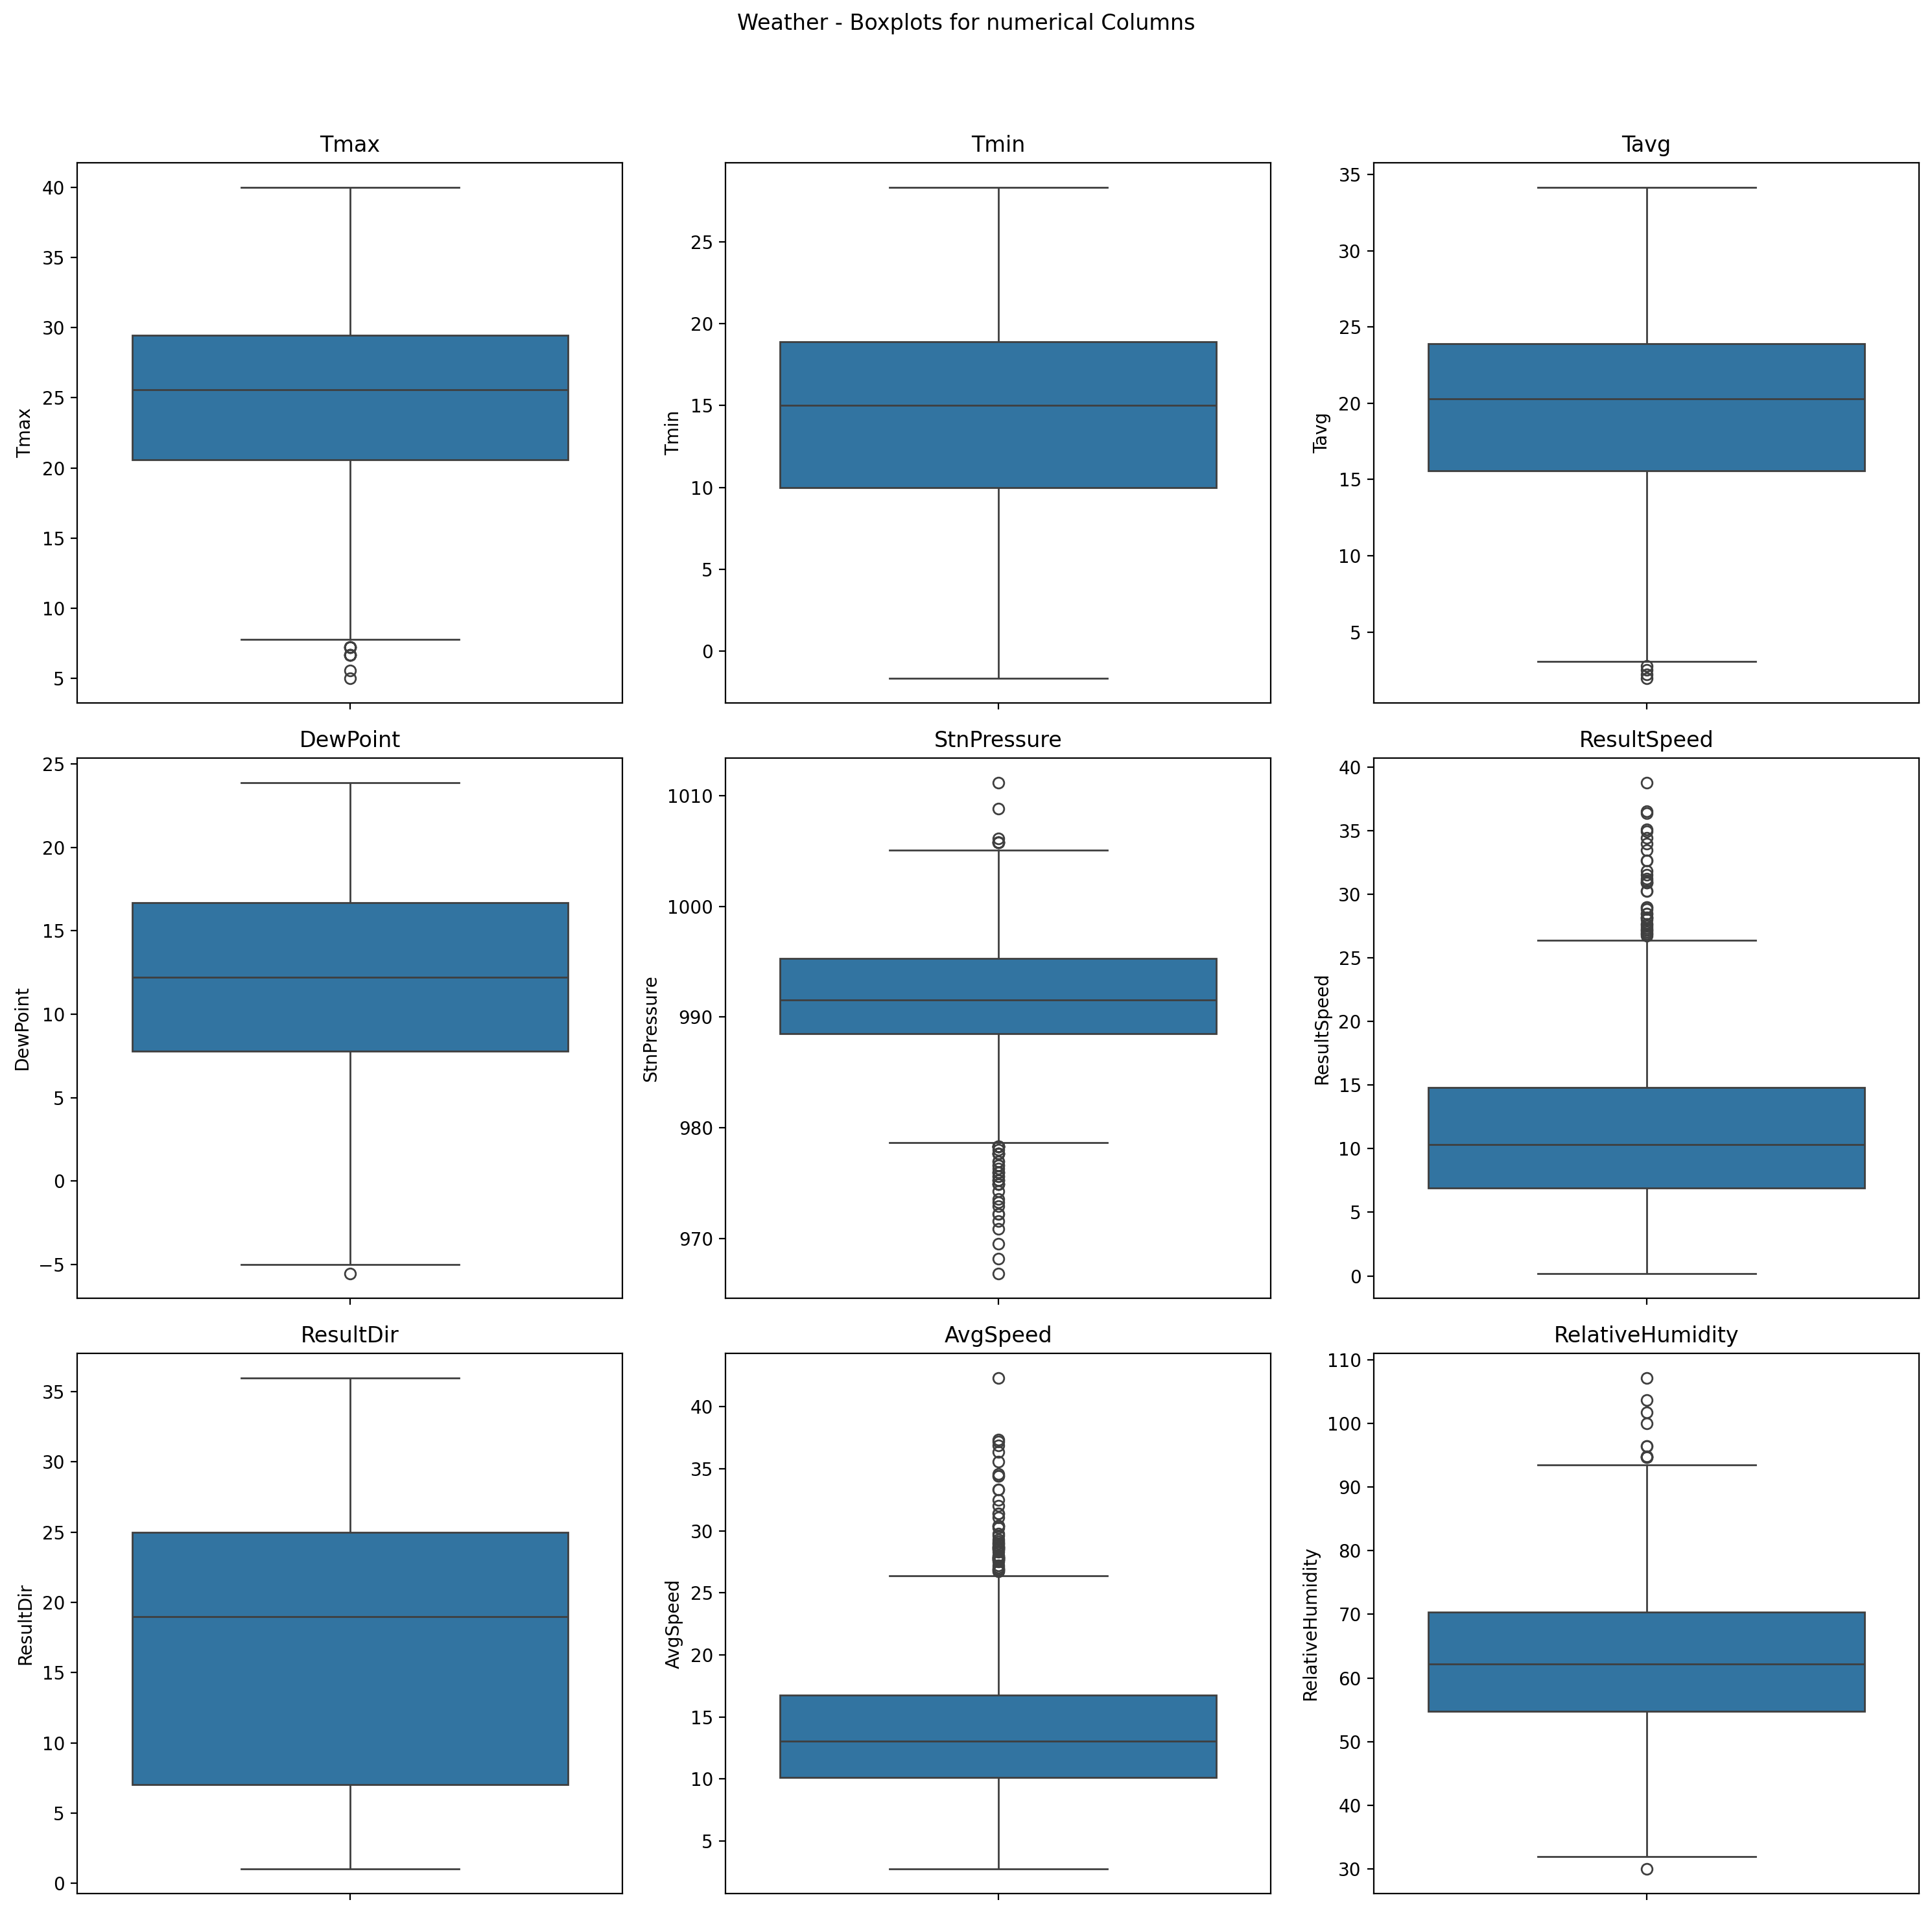

### Tmax Summary
- Minimum: 5.0
- Q1: 20.56
- Median: 25.56
- Q3: 29.44
- Maximum: 40.0

### Tmin Summary
- Minimum: -1.67
- Q1: 10.0
- Median: 15.0
- Q3: 18.89
- Maximum: 28.33

### Tavg Summary
- Minimum: 1.9449999999999998
- Q1: 15.555
- Median: 20.28
- Q3: 23.89
- Maximum: 34.165

### DewPoint Summary
- Minimum: -5.56
- Q1: 7.78
- Median: 12.22
- Q3: 16.67
- Maximum: 23.89

### StnPressure Summary
- Minimum: 966.81
- Q1: 988.49
- Median: 991.53
- Q3: 995.26
- Maximum: 1011.18

### ResultSpeed Summary
- Minimum: 0.16
- Q1: 6.92
- Median: 10.3
- Q3: 14.81
- Maximum: 38.79

### ResultDir Summary
- Minimum: 1
- Q1: 7.0
- Median: 19.0
- Q3: 25.0
- Maximum: 36

### AvgSpeed Summary
- Minimum: 2.74
- Q1: 10.14
- Median: 13.04
- Q3: 16.74
- Maximum: 42.33

### RelativeHumidity Summary
- Minimum: 29.989924448746425
- Q1: 54.77339012317223
- Median: 62.175001269519925
- Q3: 70.32515933565008
- Maximum: 107.14487614445164


In [439]:
# weather_numerical = Tavg, Dewpoint, precipTotal, StnPressure, Result speed, resultDir. AvgSpeed, Relative Humidity; train_numerical NumMosquitoes, spray_numerical Latitude, longitude
# Station is either one or 2 - no need to show this in boxplot
weather_numerical.drop(["Station"], axis=1, inplace=True)
display_grid_boxplots(weather_numerical, "Weather - Boxplots for numerical Columns")
five_number_summary(weather_numerical)




**Train Outlier Detection - Numerical Attributes**

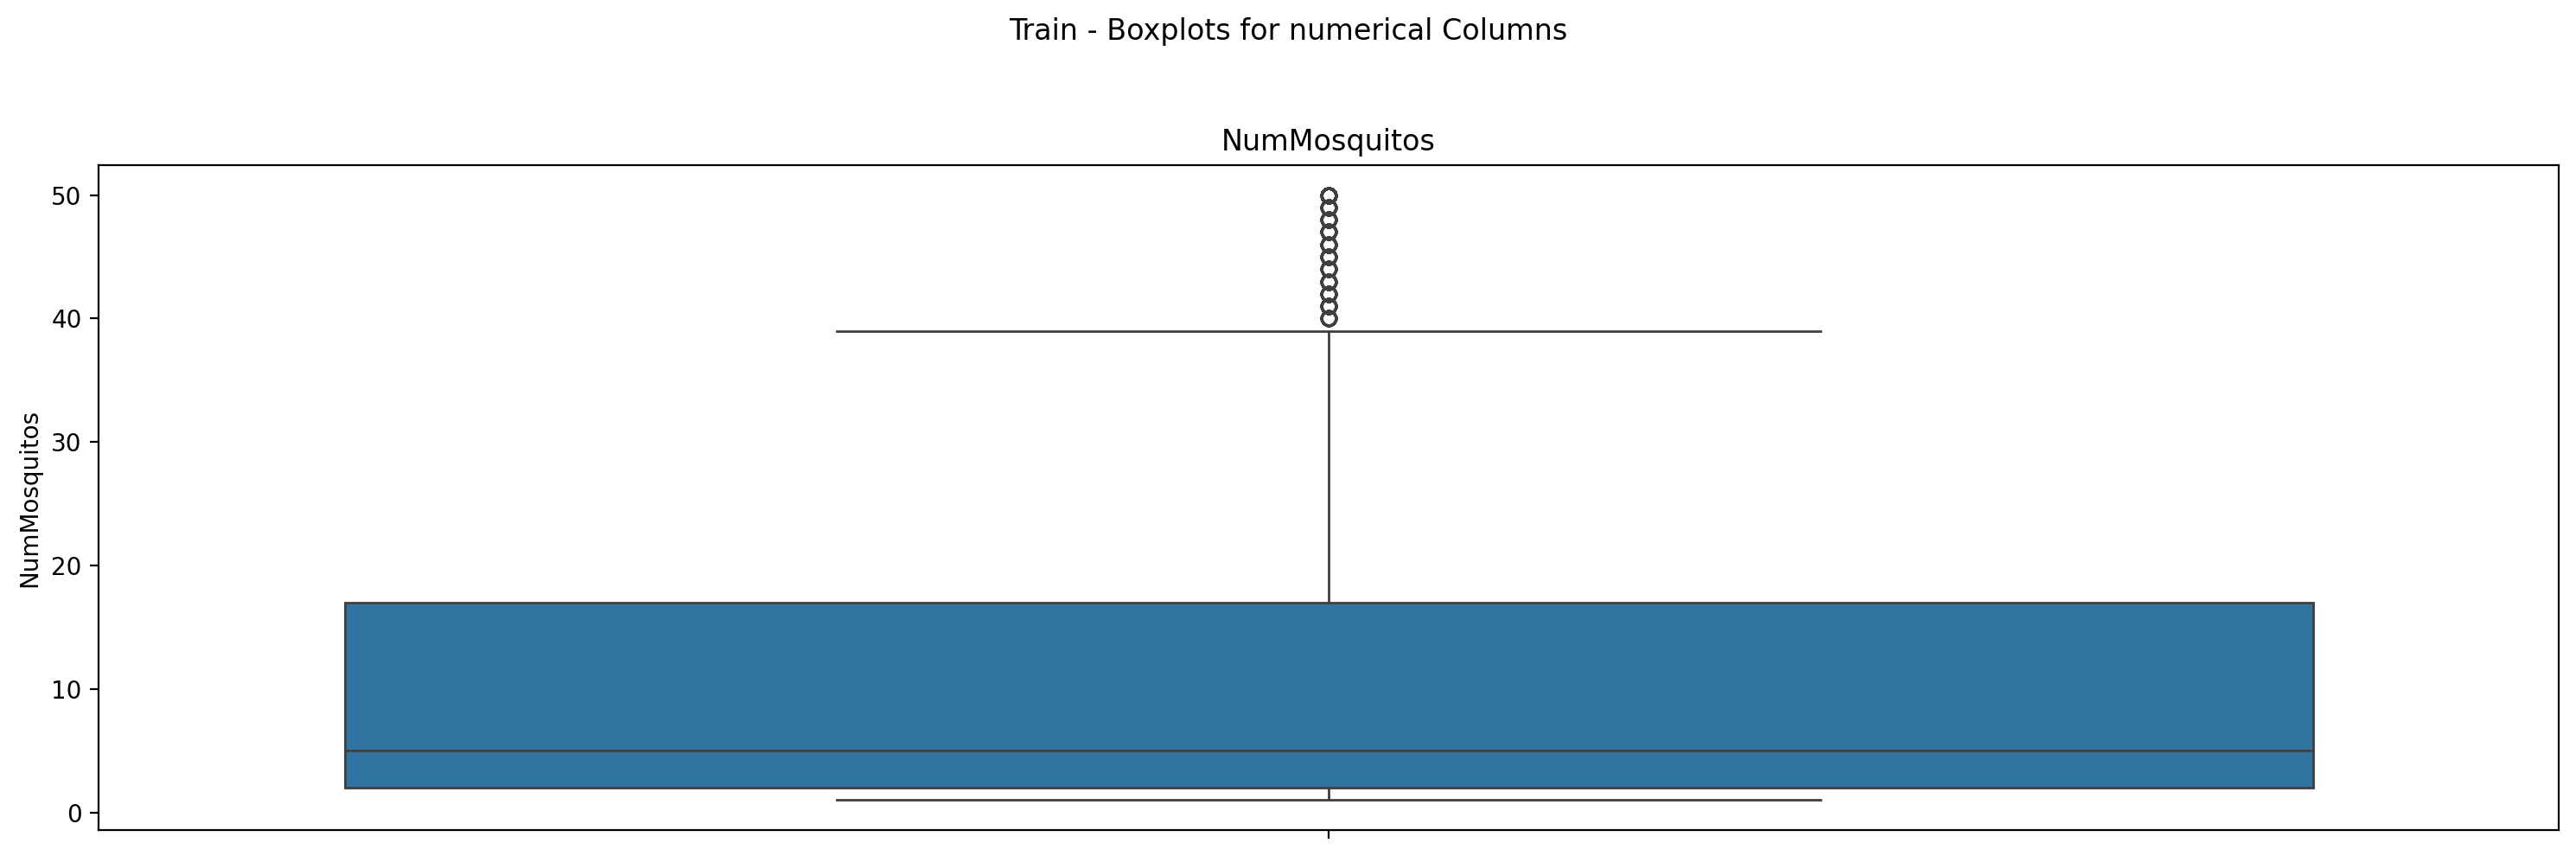

### NumMosquitos Summary
- Minimum: 1
- Q1: 2.0
- Median: 5.0
- Q3: 17.0
- Maximum: 50


In [440]:


train_numerical.drop(["WnvPresent"], axis=1, inplace=True)

display_grid_boxplots(train_numerical, "Train - Boxplots for numerical Columns")
five_number_summary(train_numerical)


**Train Outlier Detection - Categorical Attributes**

C:\Users\nilst\AppData\Local\Temp\ipykernel_16072\4129951889.py:15: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  categorical_columns = [col for col in df.columns if df[col].dtype == 'object' or pd.api.types.is_categorical_dtype(df[col])]


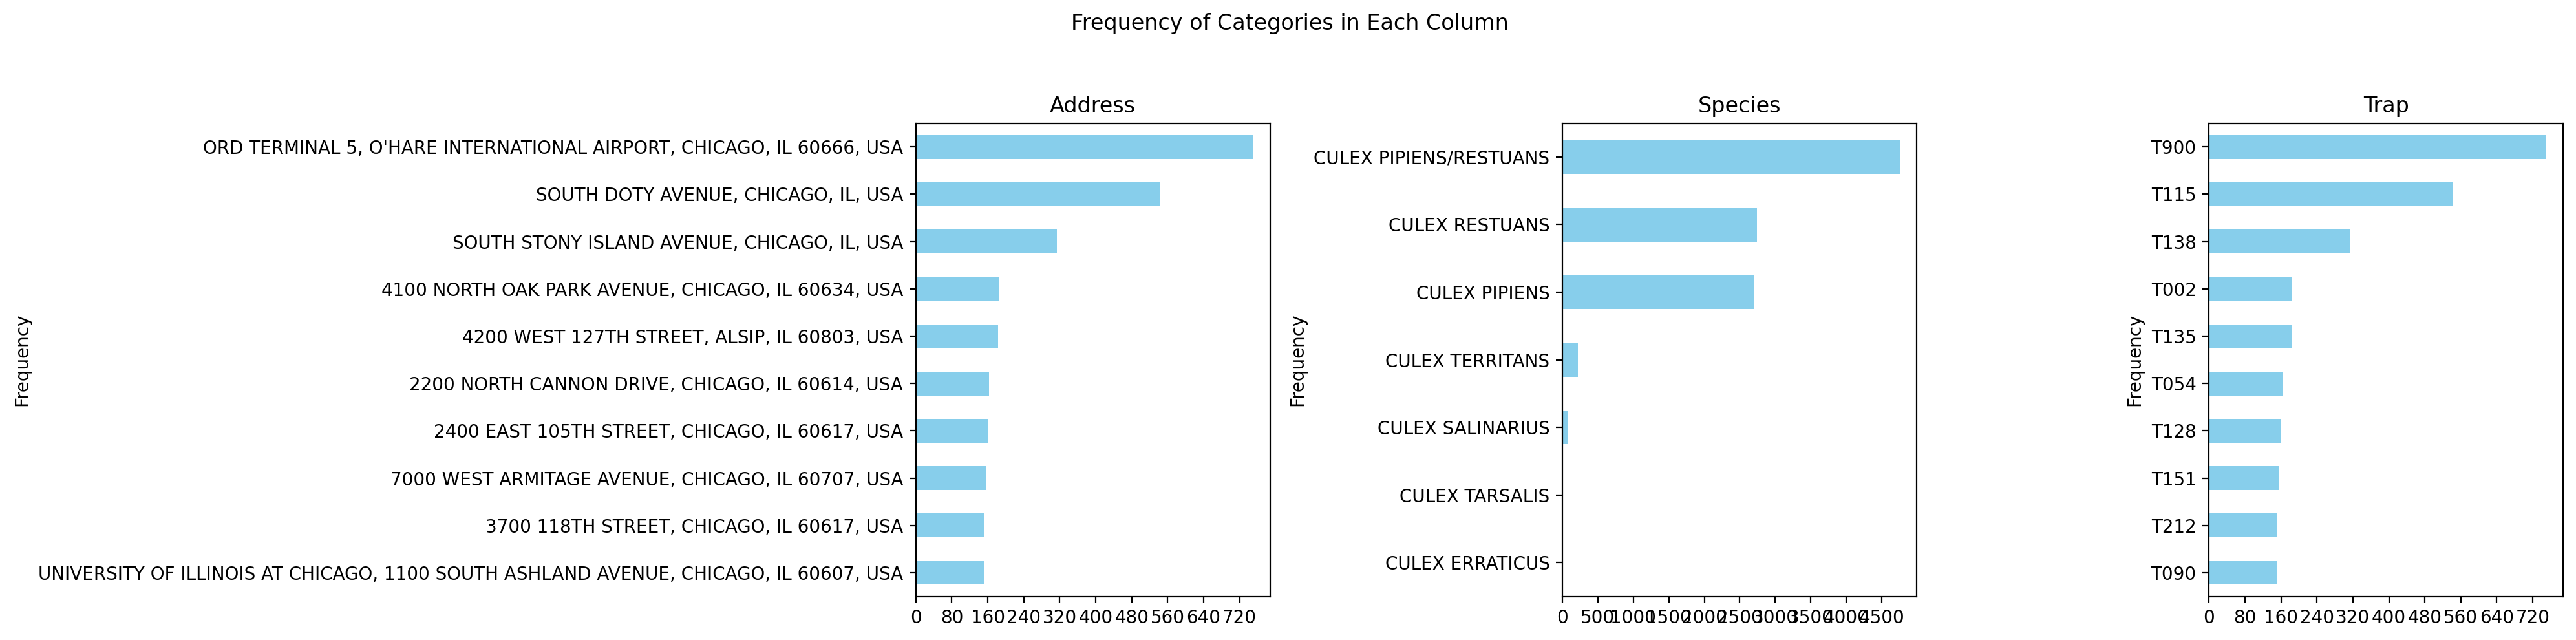

In [441]:
plot_category_frequencies_grid(train_categorical)

**Outlier Detection - Dates**

In [442]:
# check date range of our data
from IPython.display import Markdown, display

def five_summary_date(data, date_column):
    """
    Compute and display a summary for a date column in a DataFrame using Markdown.
    
    Parameters:
    - data (DataFrame): The DataFrame containing the date column.
    - date_column (str): The name of the date column to summarize.
    """
    if pd.api.types.is_datetime64_any_dtype(data[date_column]):
        # Compute statistics
        min_date = data[date_column].min()
        max_date = data[date_column].max()
        range_date = max_date - min_date
        
        # Attempt to calculate quartiles if relevant
        try:
            q1_date = data[date_column].quantile(0.25)
            median_date = data[date_column].median()
            q3_date = data[date_column].quantile(0.75)
        except TypeError:
            q1_date = "N/A"
            median_date = "N/A"
            q3_date = "N/A"
        
        # Collect the summary in Markdown format
        output = [
            f"### {date_column} Summary",
            f"- Earliest Date: {min_date.strftime('%Y-%m-%d') if pd.notna(min_date) else 'N/A'}",
            f"- Q1 Date: {q1_date.strftime('%Y-%m-%d') if pd.notna(q1_date) else 'N/A'}",
            f"- Median Date: {median_date.strftime('%Y-%m-%d') if pd.notna(median_date) else 'N/A'}",
            f"- Q3 Date: {q3_date.strftime('%Y-%m-%d') if pd.notna(q3_date) else 'N/A'}",
            f"- Latest Date: {max_date.strftime('%Y-%m-%d') if pd.notna(max_date) else 'N/A'}",
            f"- Date Range: {range_date}"
        ]
        
        # Display output as a Markdown block
        display(Markdown('\n'.join(output)))
    else:
        print(f"The column '{date_column}' is not a datetime type.")

five_summary_date(train, 'Date')
five_summary_date(weather, 'Date')

### Date Summary
- Earliest Date: 2007-05-29
- Q1 Date: 2007-08-24
- Median Date: 2009-08-07
- Q3 Date: 2011-09-16
- Latest Date: 2013-09-26
- Date Range: 2312 days 00:00:00

### Date Summary
- Earliest Date: 2007-05-01
- Q1 Date: 2008-12-15
- Median Date: 2010-10-31
- Q3 Date: 2012-10-31
- Latest Date: 2014-10-31
- Date Range: 2740 days 00:00:00

### 4.3 Data Transformation and Integration

In [443]:
train = train.merge(weather, how='left', on=['Date'])
train.head()



,Date,Address,Species,Trap,NumMosquitos,WnvPresent,WNV_risk,Station,Tmax,Tmin,...,Precipitation,Visibility Issues,Windy,Very Hot,Very Cold,Cloudy,Atmospheric Phenomena,Storms,Miscellaneous,RelativeHumidity
0,2007-05-29,"4100 NORTH OAK PARK AVENUE, CHICAGO, IL 60634,...",CULEX PIPIENS/RESTUANS,T002,1,0,5,1,31.11,15.56,...,0,1,0,0,0,0,0,0,0,57.376195
1,2007-05-29,"4100 NORTH OAK PARK AVENUE, CHICAGO, IL 60634,...",CULEX PIPIENS/RESTUANS,T002,1,0,5,2,31.11,18.33,...,0,1,0,0,0,0,0,0,0,54.737801
2,2007-05-29,"4100 NORTH OAK PARK AVENUE, CHICAGO, IL 60634,...",CULEX RESTUANS,T002,1,0,5,1,31.11,15.56,...,0,1,0,0,0,0,0,0,0,57.376195
3,2007-05-29,"4100 NORTH OAK PARK AVENUE, CHICAGO, IL 60634,...",CULEX RESTUANS,T002,1,0,5,2,31.11,18.33,...,0,1,0,0,0,0,0,0,0,54.737801
4,2007-05-29,"6200 NORTH MANDELL AVENUE, CHICAGO, IL 60646, USA",CULEX RESTUANS,T007,1,0,1,1,31.11,15.56,...,0,1,0,0,0,0,0,0,0,57.376195


In [444]:

analyze_dataframe(train, "Train")


### Train DataFrame Analysis

#### Now that weve merged the Data on Date, we can extract Month, Year, "Year Month" and Day

In [445]:


train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Day'] = train['Date'].dt.day
train.drop(["Date"], axis=1, inplace=True)

### Comparing new Correlation Heatmap with the original one (see Data Understanding)

,NumMosquitos,WnvPresent,WNV_risk,Station,Tmax,Tmin,Tavg,DewPoint,StnPressure,ResultSpeed,...,PrecipTotal_0.87,PrecipTotal_0.88,PrecipTotal_0.89,PrecipTotal_0.92,PrecipTotal_0.95,PrecipTotal_1.19,PrecipTotal_1.31,PrecipTotal_1.55,PrecipTotal_3.97,PrecipTotal_M
0,1,0,5,1,31.11,15.56,23.335,14.44,995.26,9.33,...,False,False,False,False,False,False,False,False,False,False
1,1,0,5,2,31.11,18.33,24.720,15.00,996.95,9.33,...,False,False,False,False,False,False,False,False,False,False
2,1,0,5,1,31.11,15.56,23.335,14.44,995.26,9.33,...,False,False,False,False,False,False,False,False,False,False
3,1,0,5,2,31.11,18.33,24.720,15.00,996.95,9.33,...,False,False,False,False,False,False,False,False,False,False
4,1,0,1,1,31.11,15.56,23.335,14.44,995.26,9.33,...,False,False,False,False,False,False,False,False,False,False


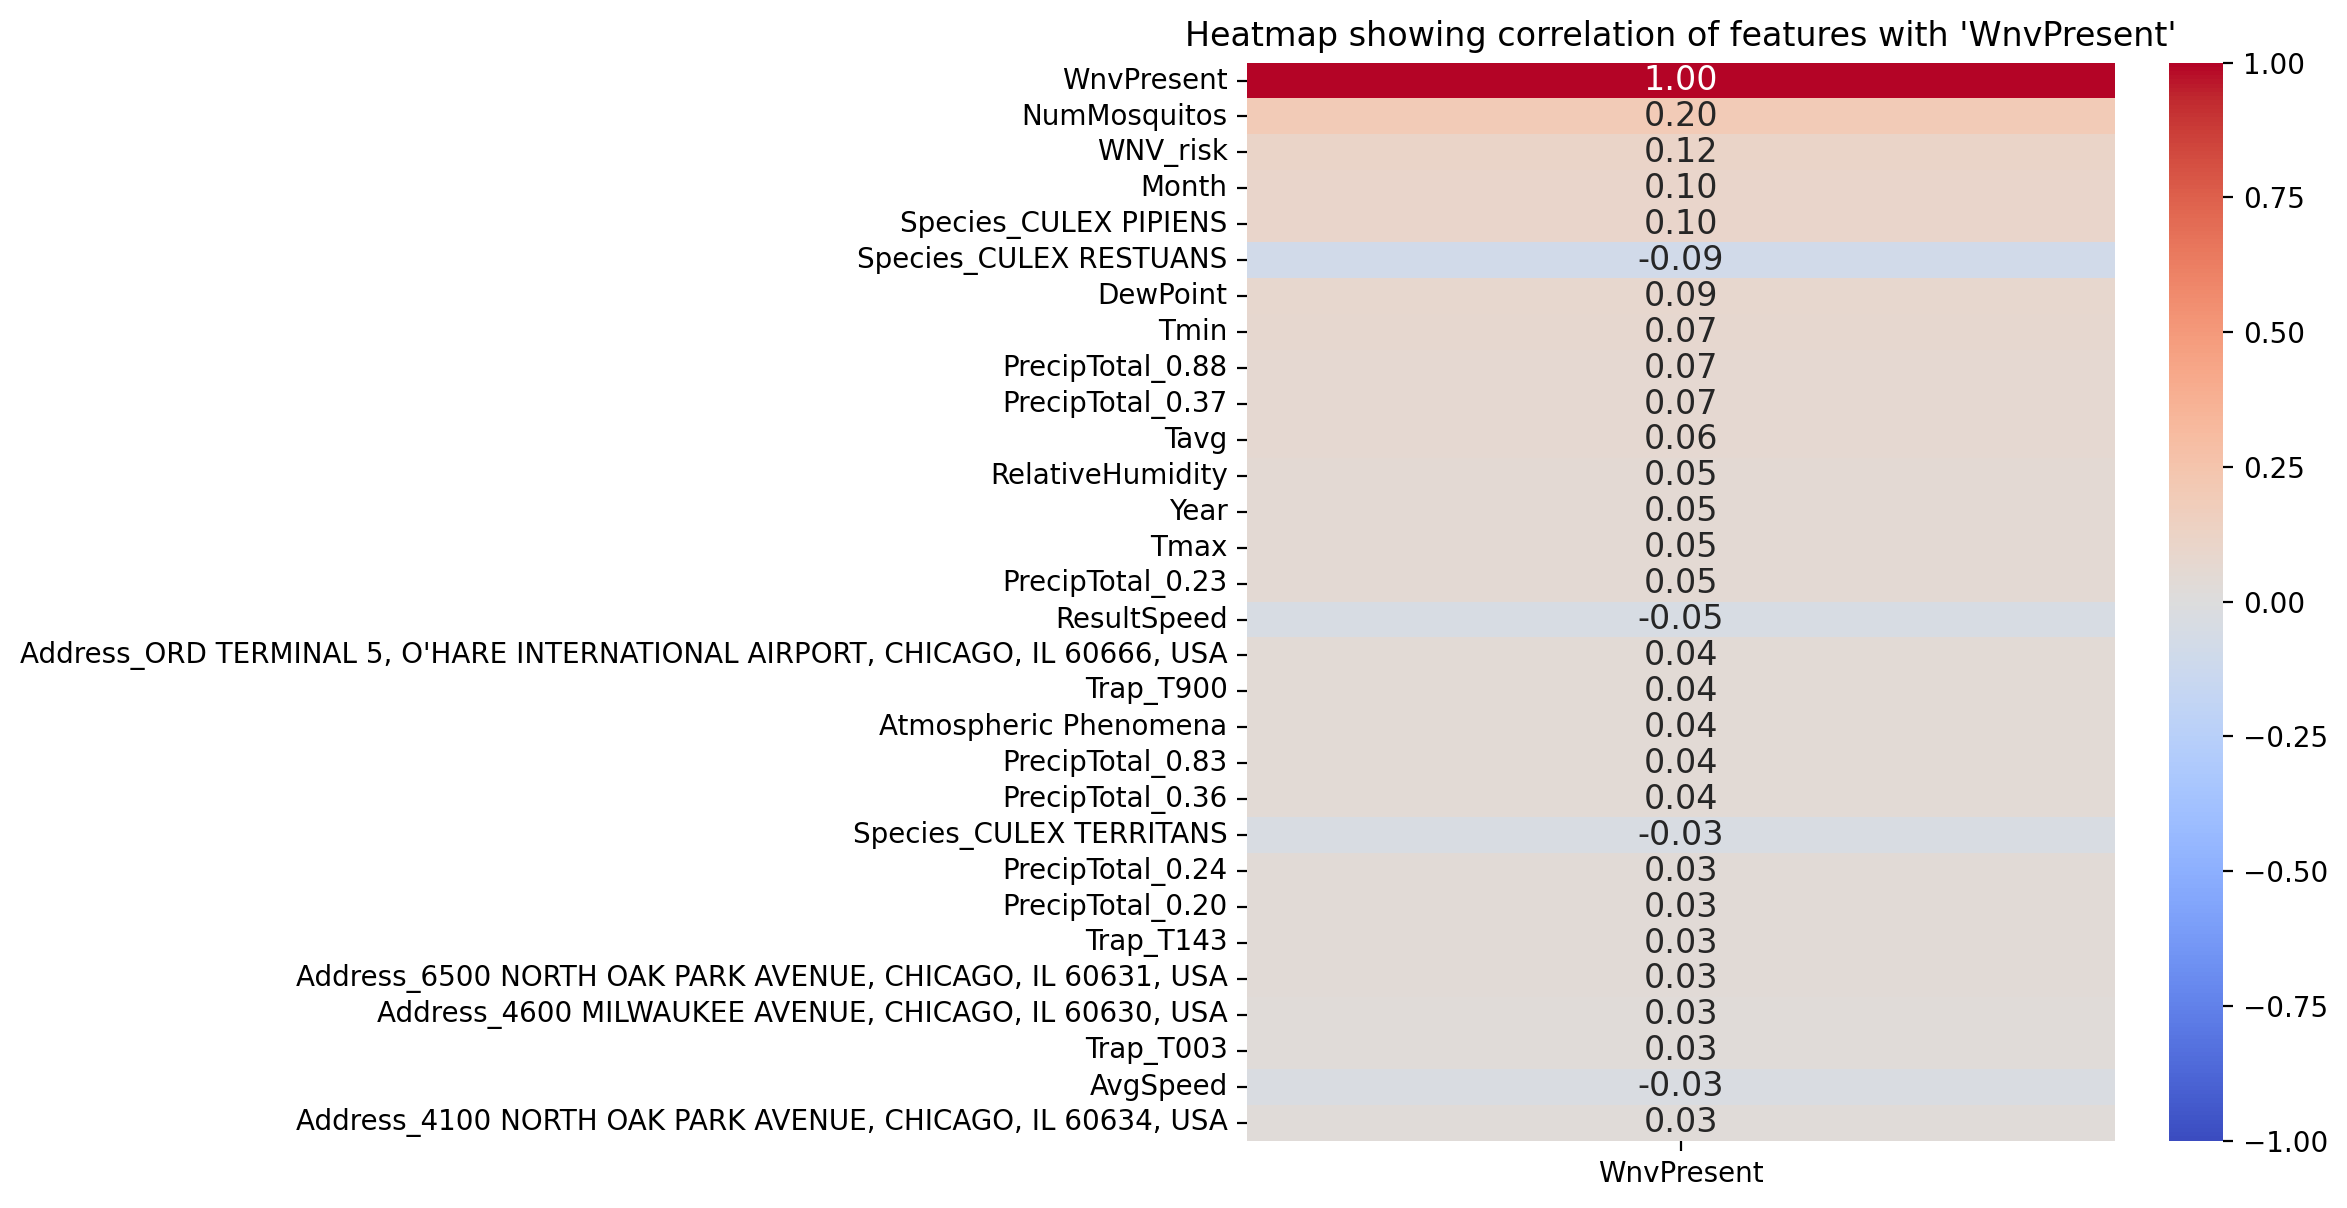

In [446]:
def plot_heatmap(data):
    # Dropping these columns, for the Heatmap sicnce they have many unique values and crowd the  correlation matrix
    data.drop(columns=[], inplace=True)
    data_encoded = pd.get_dummies(data)
    display(data_encoded.head())

    # Calculate the correlation matrix
    correlation_matrix = data_encoded.corr()

    # Extract the correlation with 'WnvPresent' and sort it
    target_correlation = correlation_matrix['WnvPresent'].abs().sort_values(ascending=False).head(30)

    # Prepare the dataframe for plotting: focusing only on correlations with 'WnvPresent'
    for_heatmap = correlation_matrix.loc[target_correlation.index, ['WnvPresent']]

    # Plotting the heatmap
    plt.figure(figsize=(7, 7))
    sns.heatmap(for_heatmap, annot=True, cmap="coolwarm", fmt=".2f", annot_kws={"size": 12}, vmin=-1, vmax=1)
    plt.title("Heatmap showing correlation of features with 'WnvPresent'")
    plt.show()

plot_heatmap(train)




As we can see, some of the extracted Variables correlate higher than some of the original Data

In [447]:
test.to_csv('../data/cleaned_test.csv', index=False)
train.to_csv('../data/cleaned_train.csv', index=False)
